In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

In [2]:
dirpath = '/home/jackalhan/Development/github/more_meaningful_representations/squad/dev/comparisions/Best_Weights/with_new_tokenization'
each_file = 'elmo_with_idf_weights_a_1_b_0_c_0_output_filtered_answers_neighbors.csv'

In [3]:
#RECALL AT KS
# mypath = '/home/jackalhan/Development/github/more_meaningful_representations/squad/dev/comparisions/Weights'
# for (dirpath, dirnames, filenames) in os.walk(mypath):    
#     performance = []
#for each_file in filenames:
performance = []
print(each_file)
neighbors = pd.read_csv(os.path.join(dirpath, each_file))
if 'neighbor_filtered_order' in neighbors.columns:
    del neighbors['neighbor_order']
    neighbors['neighbor_order'] = neighbors['neighbor_filtered_order']
neighbors['Is_Actual_Paragraph'] = (neighbors['neighbor_paragraph'] == neighbors['actual_paragraph']).astype('int')
number_of_questions = len(neighbors.groupby('question'))
neighbors.sort_values(by=['neighbor_cos_similarity'], ascending=[False], inplace=True)
for k in [1,2,5,10,20,50]:
    top_k = neighbors[neighbors['neighbor_order'] <= k]
    len_of_received_relevant_doc = top_k[top_k['Is_Actual_Paragraph'] == 1]['Is_Actual_Paragraph'].count()
    performance.append((k, each_file.replace('_output_neighbors.csv', ''), len_of_received_relevant_doc, len_of_received_relevant_doc/number_of_questions
                        ))
df_performance_model = pd.DataFrame(data=performance, columns=['top_n','conf', 'recall', 'normalized_recall'])
df_performance_model.sort_values(by=['top_n', 'normalized_recall'], ascending=[True, False], inplace=True)
df_performance_model.to_csv(os.path.join(dirpath, 'performances.csv'))

elmo_with_idf_weights_a_1_b_0_c_0_output_filtered_answers_neighbors.csv


In [4]:
def calculate_new_score(best_score, original_score):
    return original_score - 0.999999999 * best_score

def calculate_precision_recall(row, number_of_questions):    
    if row['Is_Actual_Paragraph'] == 1:
        global global_relevant_counter
        global_relevant_counter +=1
    recall = global_relevant_counter/number_of_questions
    precision = global_relevant_counter/(row.name + 1)
    return precision, recall

def calculate_top1_top2_delta(top1_score, top2_score):
    return top1_score - top2_score

In [5]:
#P/R and MAP
# for (dirpath, dirnames, filenames) in os.walk(mypath):    
#     performance = []
#     for each_file in filenames:
print(each_file)
cols = ['question','neighbor_paragraph','neighbor_order','neighbor_cos_similarity','actual_paragraph']
neighbors = pd.read_csv(os.path.join(dirpath, each_file) , usecols=cols)
neighbors['Is_Actual_Paragraph'] = (neighbors['neighbor_paragraph'] == neighbors['actual_paragraph']).astype('int')
number_of_questions = int(len(neighbors.groupby('question')))
number_of_paragraphs = int(len(neighbors) / number_of_questions)
neighbors.sort_values(by=['question'], ascending=[True], inplace=True)
neighbors['new_score'] = np.nan
#x_main = pd.DataFrame()
for _ in tqdm_notebook(range(0, int(number_of_questions))):
    #x_sub = neighbors[neighbors['question'] == _]
    _begin_index = _ * number_of_paragraphs
    _end_index = _begin_index + number_of_paragraphs 
    #print(_begin_index, _end_index)
    _max_score_of_this_q_set = neighbors.iloc[_begin_index:_end_index]['neighbor_cos_similarity'].max()
    #_max_score_of_this_q_set = x['neighbor_cos_similarity'].max()    
    neighbors.iloc[_begin_index:_end_index, neighbors.columns.get_loc('new_score')] = neighbors.iloc[_begin_index:_end_index].apply(lambda x : 
                                                                   calculate_new_score(_max_score_of_this_q_set, x['neighbor_cos_similarity']), axis=1)

#     x_sub['new_score'] = x_sub.apply(lambda x : calculate_new_score(_max_score_of_this_q_set, 
#                                                                                        x['neighbor_cos_similarity']), axis=1)
#     x_main = x_main.append(x_sub)

neighbors.sort_values(by=['new_score'], ascending=[False], inplace=True)
neighbors.to_csv(os.path.join(dirpath, 'new_scores_' + each_file))    

elmo_with_idf_weights_a_1_b_0_c_0_output_filtered_answers_neighbors.csv


HBox(children=(IntProgress(value=0, max=10570), HTML(value='')))

In [6]:
# PRECISION RECALL CALCULATION
neighbors = pd.read_csv(os.path.join(dirpath, 'new_scores_' + each_file))    
temp_df_new_scores = neighbors[neighbors['Is_Actual_Paragraph'] == 1]
max_index = temp_df_new_scores['new_score'].idxmin()
neighbors = neighbors[neighbors.index <= max_index]
neighbors.sort_values(by=['new_score'], ascending=[False], inplace=True)
neighbors = neighbors.reset_index(drop=True)
number_of_questions = len(neighbors.groupby('question'))
number_of_paragraphs = len(neighbors) / number_of_questions
global_relevant_counter = 0
neighbors['precision'], neighbors['recall'] = zip(*neighbors.apply(lambda x : calculate_precision_recall(x,number_of_questions), axis=1))
df_precision_recall =neighbors[['precision', 'recall', 'Is_Actual_Paragraph']]
df_precision_recall.to_csv(os.path.join(dirpath, 'pr_' + each_file))

Text(0.5,1,'Precision-Recall curve for 10570 docs from 10570 pairs : AP=1.00')

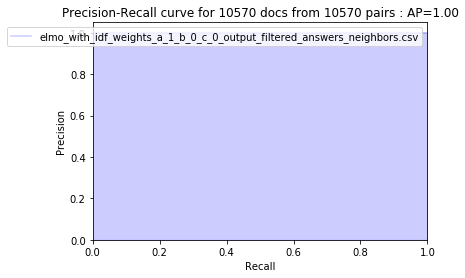

In [7]:
#AP CALCULATION AND CURVE
df_precision_recall = pd.read_csv(os.path.join(dirpath, 'pr_' + each_file))  
df_precision_recall_filtered = df_precision_recall[df_precision_recall['Is_Actual_Paragraph'] == 1]
ap = df_precision_recall_filtered["precision"].mean()
ap
plt.step(df_precision_recall_filtered['recall'], df_precision_recall_filtered['precision'], color='b', alpha=0.2,
                 where='post')
plt.fill_between(df_precision_recall_filtered['recall'], df_precision_recall_filtered['precision'], step='post', alpha=0.2,
                 color='b')   
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend([each_file.replace('_output_neighbors.csv', '')],loc="upper right")
plt.title('Precision-Recall curve for ' + str(number_of_questions) + ' docs from '+str(len(df_precision_recall))+' pairs : AP={0:0.2f}'.format(ap))

In [ ]:
#SANITY CHECK DOUBLE CHECK BY USING THE SKLEARN LIBRARIES
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(neighbors['Is_Actual_Paragraph'], neighbors['new_score'])

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(neighbors['Is_Actual_Paragraph'], neighbors['new_score'])

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve for ' + str(number_of_questions) + ' docs from '+str(len(df_precision_recall))+' pairs : AP={0:0.2f}'.format(average_precision))

In [ ]:
# TOP1 - TOP2 DELTA
#P/R and MAP
# for (dirpath, dirnames, filenames) in os.walk(mypath):    
#     performance = []
#     for each_file in filenames:
print(each_file)
cols = ['question','neighbor_paragraph','neighbor_order','neighbor_cos_similarity','actual_paragraph']
neighbors = pd.read_csv(os.path.join(dirpath, each_file) , usecols=cols)
neighbors['Is_Actual_Paragraph'] = (neighbors['neighbor_paragraph'] == neighbors['actual_paragraph']).astype('int')
number_of_questions = len(neighbors.groupby('question'))
number_of_paragraphs = len(neighbors) / number_of_questions
neighbors.sort_values(by=['question'], ascending=[True], inplace=True)
neighbors['top1_top2_delta'] = np.nan
for _ in tqdm_notebook(range(0, int(number_of_paragraphs))):  
    _begin_index = _ * number_of_questions
    _end_index = _begin_index + number_of_questions 
    _max_score_of_this_q_set = neighbors.iloc[_begin_index:_end_index]['neighbor_cos_similarity'].nlargest(1).values[0]
    _second_max_score_of_this_q_set = neighbors.iloc[_begin_index:_end_index]['neighbor_cos_similarity'].nlargest(2).values[0]
    neighbors.iloc[_begin_index:_end_index, neighbors.columns.get_loc('top1_top2_delta')] = neighbors.iloc[_begin_index:_end_index].apply(lambda x : 
                                                                   calculate_top1_top2_delta(_max_score_of_this_q_set, 
                                                                                       _second_max_score_of_this_q_set), axis=1)


In [ ]:
import sys
sys.float_info.epsilon
x = neighbors[neighbors['Is_Actual_Paragraph'] == 1]
len(x[x['top1_top2_delta'] > sys.float_info.epsilon])

In [ ]:
neighbors.iloc[_begin_index:_end_index]

In [ ]:
_second_max_score_of_this_q_set